In [101]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;

In [102]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

In [103]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [104]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

In [105]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [106]:
train.describe(include=['O', 'category'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


[1 3 0 2]


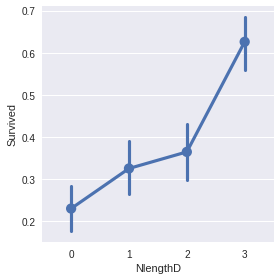

In [107]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
for dataset in full_data:
    dataset['Name_length'] = dataset['Name'].apply(len)
    dataset['NlengthD'] = pd.qcut(dataset['Name_length'], 4, labels=[0,1,2,3]).astype(int)
sns.factorplot(x="NlengthD", y="Survived", data=train,order=[0,1,2,3])
print(train["NlengthD"].unique())

[ 1.  0.  2.]
0.0    537
1.0    263
2.0     91
Name: FsizeD, dtype: int64


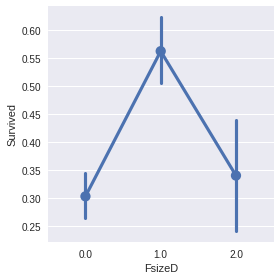

In [108]:
# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
smallbig=3
for dataset in full_data:
    dataset.loc[dataset["FamilySize"] == 1, "FsizeD"] = 0
    dataset.loc[(dataset["FamilySize"] > 1)  &  (dataset["FamilySize"] <= smallbig) , "FsizeD"] = 1
    dataset.loc[dataset["FamilySize"] >smallbig, "FsizeD"] = 2

print(train["FsizeD"].unique())
print(train["FsizeD"].value_counts())
sns.factorplot(x="FsizeD", y="Survived", data=train);
del dataset['FamilySize']

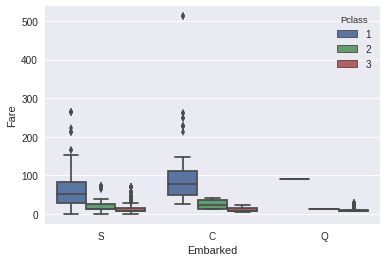

In [109]:
sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=train);
train[train['Embarked'].isnull()]
train["Embarked"] = train["Embarked"].fillna('C')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare

In [110]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,NlengthD,FsizeD
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,18,0,0.0


In [111]:
median = test[(test.Pclass==3)&(test.Embarked=='S')]['Fare'].median()
test["Fare"] = test["Fare"].fillna(median)

In [112]:
for dataset in full_data:
    for i in ['male','female']:
        for j in range(1, 4):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j)]['Age'].dropna()

            age_mean = guess_df.mean()
            age_std = guess_df.std()
            size=dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j)]['Age'].isnull().sum()
            guess_ages = np.random.randint(age_mean - age_std, age_mean + age_std,size=size)
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j),\
                    'Age'] = guess_ages

    dataset['Age'] = dataset['Age'].astype(int)

In [113]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    #title_search.group() == title_search.group(0)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [114]:
for dataset in full_data:
    dataset['CategoricalAge'] = pd.cut(dataset['Age'], 5,labels=[0,1,2,3,4]).astype(int)
    dataset['CategoricalFare'] = pd.qcut(dataset['Fare'], 4,labels=[0,1,2,3]).astype(int)

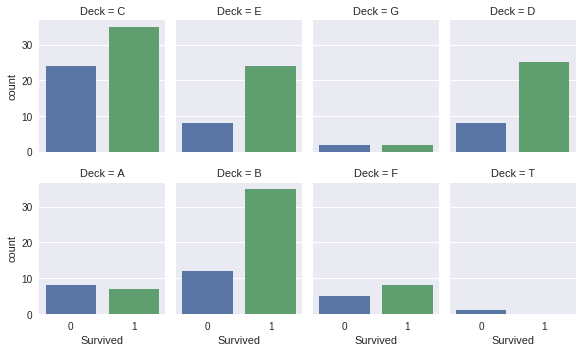

In [115]:
for dataset in full_data:
    dataset["Deck"]=dataset.Cabin.str[0]
g = sns.factorplot("Survived", col="Deck", col_wrap=4,
                    data=train[train.Deck.notnull()],
                    kind="count", size=2.5, aspect=.8);

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked, Name_length, NlengthD, FamilySize, FsizeD, Title, CategoricalAge, CategoricalFare, Deck]
Index: []


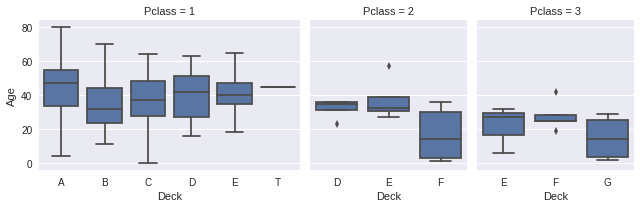

In [116]:
train = train.assign(Deck=train.Deck.astype(object)).sort_values("Deck")
g = sns.FacetGrid(train, col="Pclass", sharex=False,
                  gridspec_kws={"width_ratios": [5, 3, 3]})
g.map(sns.boxplot, "Deck", "Age");
print train[(train.Deck=='D') & (train.Pclass==3)]

In [117]:
train.Deck.fillna('Z', inplace=True)
test.Deck.fillna('Z', inplace=True)

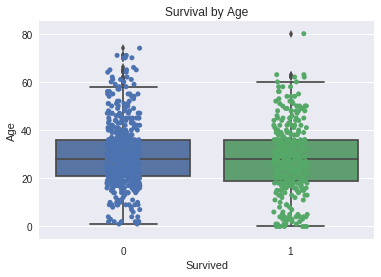

In [118]:
ax = sns.boxplot(x="Survived", y="Age", 
                data=train)
ax = sns.stripplot(x="Survived", y="Age",
                   data=train, jitter=True,
                   edgecolor="gray")
sns.plt.title("Survival by Age",fontsize=12);

In [119]:
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
train['Person'] = train[['Age','Sex']].apply(get_person,axis=1)
test['Person']    = test[['Age','Sex']].apply(get_person,axis=1)

In [120]:
del train['Name']
del train['PassengerId']
del train['SibSp']
del train['Parch']
del train['Ticket']

In [121]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Name_length,NlengthD,FamilySize,FsizeD,Title,CategoricalAge,CategoricalFare,Deck,Person
475,0,1,male,47,52.0000,A14,S,27,2,1,0.0,Mr,2,3,A,male
174,0,1,male,56,30.6958,A7,C,23,1,1,0.0,Mr,3,2,A,male
209,1,1,male,40,31.0000,A31,C,16,0,1,0.0,Mr,2,2,A,male
445,1,1,male,4,81.8583,A34,S,25,1,3,1.0,Master,0,3,A,child
647,1,1,male,56,35.5000,A26,C,35,3,1,0.0,Rare,3,3,A,male


In [122]:
train.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

In [123]:
trainX=train[['Survived','Pclass','CategoricalFare','CategoricalAge','FsizeD','NlengthD']].copy()
testX = test[['Pclass','CategoricalFare','CategoricalAge','FsizeD','NlengthD']].copy()
#get_dummies
#Convert categorical variable into dummy/indicator variables
trainX=trainX.join(pd.get_dummies(train['Person']))
#trainX=trainX.join(pd.get_dummies(train['Deck']))
trainX=trainX.join(pd.get_dummies(train['Title']))
trainX=trainX.join(pd.get_dummies(train['Embarked'], prefix='e'))
testX=testX.join(pd.get_dummies(test['Person']))
#testX=testX.join(pd.get_dummies(test['Deck']))
testX=testX.join(pd.get_dummies(test['Title']))
testX=testX.join(pd.get_dummies(test['Embarked'], prefix='e'))
print trainX.shape
print testX.shape
print trainX.columns
print testX.columns

(891, 17)
(418, 16)
Index([u'Survived', u'Pclass', u'CategoricalFare', u'CategoricalAge',
       u'FsizeD', u'NlengthD', u'child', u'female', u'male', u'Master',
       u'Miss', u'Mr', u'Mrs', u'Rare', u'e_C', u'e_Q', u'e_S'],
      dtype='object')
Index([u'Pclass', u'CategoricalFare', u'CategoricalAge', u'FsizeD',
       u'NlengthD', u'child', u'female', u'male', u'Master', u'Miss', u'Mr',
       u'Mrs', u'Rare', u'e_C', u'e_Q', u'e_S'],
      dtype='object')


In [212]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = trainX['Survived'].ravel()
x_train = trainX.drop(['Survived'], axis=1).values # Creates an array of the train data
y1_train = trainX['Survived'].ravel()
x1_train = trainX.drop(['Survived'], axis=1).values # Creates an array of the train data

x_test = testX.values # Creats an array of the test data
print x_train.shape
print y_train.shape
print x_test.shape

(891, 16)
(891,)
(418, 16)


In [ ]:
param_grid = dict(gamma=np.logspace(-3, 3, 17), C=np.logspace(-3, 3, 17),kernel=['rbf'])
cv = StratifiedKFold(n_splits=5,random_state=42)
gridsvc2 = GridSearchCV(SVC(), param_grid=param_grid, cv=cv,n_jobs=-1)
gridsvc2.fit(x_train, y_train)
print("The best parameters are %s with a score of %0.8f"% \
      (gridsvc2.best_params_, gridsvc2.best_score_))

#print gridsvc2.cv_results_['param_C']
#print gridsvc2.cv_results_['param_gamma']
#print gridsvc2.cv_results_['mean_test_score']
sns.barplot(x='param_C',y='mean_test_score',hue='param_gamma',data=gridsvc2.cv_results_)

In [ ]:
parameter_grid = {
             'max_depth' : [4, 6, 8],
             'n_estimators': [700],
             'max_features' : ['sqrt', 'log2'],
             'min_samples_split': [2, 3, 10],
             'min_samples_leaf': [2, 3, 10],
             'bootstrap': [True, False],
             }

grid_search = GridSearchCV(RandomForestClassifier(),
                           scoring='accuracy',
                           param_grid=parameter_grid,n_jobs=-1,
                           cv=StratifiedKFold(n_splits=5,random_state=42))

grid_search.fit(x_train, y_train)
parameters = grid_search.best_params_

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

In [214]:
from sklearn.metrics import accuracy_score
SEED=42
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((x_train.shape[0],))
    skf = StratifiedKFold(n_splits=5,random_state=42)
    skf.get_n_splits(x_train,y_train)
    oof_test = np.zeros((x_test.shape[0],))

    for train_index, test_index in skf.split(x_train,y_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        clf.fit(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test += clf.predict(x_test)
        

    oof_test = oof_test / 5.0
    print accuracy_score(y_train,oof_train.reshape(-1))
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [216]:
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}
et = ExtraTreesClassifier(**et_params)
et_oof_train, et_oof_test = get_oof(et,x_train,y_train,x_test)

0.824915824916


In [217]:
rf_params = {'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 700, 
             'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 6}
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}
rf = RandomForestClassifier(**rf_params)
rf_oof_train, rf_oof_test = get_oof(rf,x_train,y_train,x_test)

0.843995510662


In [218]:
ada_params = {
    'n_estimators': 1000,
    'learning_rate' : 0.05
}
ada = AdaBoostClassifier(**ada_params)
ada_oof_train, ada_oof_test = get_oof(ada,x_train,y_train,x_test)

0.805836139169


In [219]:
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}
gb = GradientBoostingClassifier(**gb_params)
gb_oof_train, gb_oof_test = get_oof(gb,x_train,y_train,x_test)

0.819304152637


In [220]:
svc_params = {'kernel': 'rbf', 'C': 31.622776601683793, 'gamma': 0.0023713737056616554}
svc_oof_train, svc_oof_test = get_oof(SVC(**svc_params),x_train,y_train,x_test)

0.824915824916


**Feature importances generated from the different classifiers**

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in **.feature_importances_**. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances as such

In [195]:
rf_features = rf.feature_importances_
et_features = et.feature_importances_
ada_features = ada.feature_importances_
gb_features = gb.feature_importances_

So I have not yet figured out how to assign and store the feature importances outright. Therefore I'll print out the values from the code above and then simply copy and paste into Python lists as below (sorry for the lousy hack)

Create a dataframe from the lists containing the feature importance data for easy plotting via the Plotly package.

In [196]:
print gb_features
cols = trainX.columns.values[1:]
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

[ 0.11019992  0.17196691  0.14599654  0.09019346  0.23086697  0.02307012
  0.02341752  0.01635151  0.01232317  0.03141454  0.04393312  0.02841539
  0.00284873  0.03187051  0.00541726  0.03171433]


**Interactive feature importances via Plotly scatterplots**

I'll use the interactive Plotly package at this juncture to visualise the feature importances values of the different classifiers 

Now let us calculate the mean of all the feature importances and store it as a new column in the feature importance dataframe

In [166]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.024,0.147726,0.132924,0.130820,Pclass,0.108867
1,0.060,0.050572,0.144485,0.044092,CategoricalFare,0.074787
2,0.106,0.024931,0.173018,0.024542,CategoricalAge,0.082123


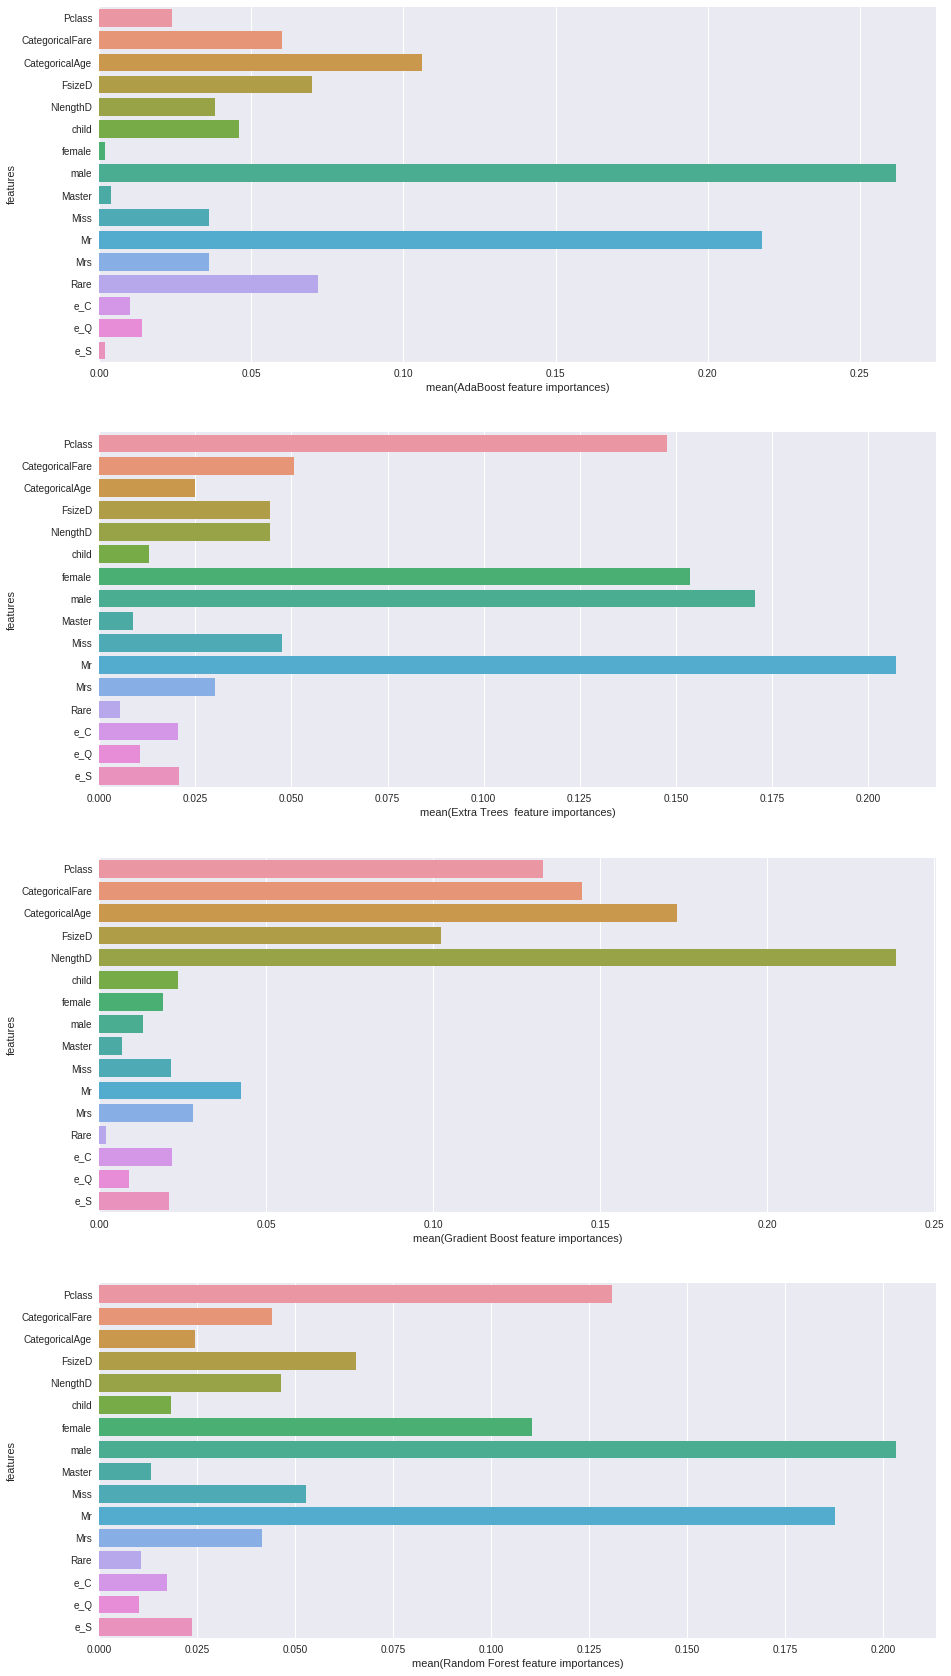

In [167]:
_,ax=plt.subplots(4,1,figsize=(15,30))
for i,classify in enumerate(feature_dataframe.columns.values[:4:]):
    sns.barplot(y='features',x=classify,data=feature_dataframe,ax=ax[i])

# Second-Level Predictions from the First-level Output

**First-level output as new features**

Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [197]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0
4,0.0,0.0,1.0,0.0


**Correlation Heatmap of the Second Level Training set**

There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores.

In [198]:
print et_oof_train.shape
x_train = np.concatenate(( et_oof_train, rf_oof_train,gb_oof_train,ada_oof_train,svc_oof_train), axis=1)
print x_train.shape
print y_train.shape
x_test = np.concatenate(( et_oof_test, rf_oof_test, gb_oof_test,ada_oof_test,svc_oof_test), axis=1)

(891, 1)
(891, 5)
(891,)


Having now concatenated and joined both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model.

### Second level learning model via XGBoost

Here we choose the eXtremely famous library for boosted tree learning model, XGBoost. It was built to optimize large-scale boosted tree algorithms. For further information about the algorithm, check out the [official documentation][1].

  [1]: https://xgboost.readthedocs.io/en/latest/

Anyways, we call an XGBClassifier and fit it to the first-level train and target data and use the learned model to predict the test data as follows:

In [199]:
gbm = xgb.XGBClassifier(
 learning_rate = 0.04,
 n_estimators= 4000,
 max_depth= 8,
 min_child_weight= 3,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
print accuracy_score(gbm.predict(x_train),y_train)
predictions = gbm.predict(x_test)

0.828282828283


Just a quick run down of the XGBoost parameters used in the model:

**max_depth** : How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.

**gamma** : minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.

**eta** : step size shrinkage used in each boosting step to prevent overfitting

**Producing the Submission file**

Finally having trained and fit all our first-level and second-level models, we can now output the predictions into the proper format for submission to the Titanic competition as follows:

In [200]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("simpletitanic.csv", index=False)

**Steps for Further Improvement**

As a closing remark it must be noted that the steps taken above just show a very simple way of producing an ensemble stacker. You hear of ensembles created at the highest level of Kaggle competitions which involves monstrous combinations of stacked classifiers as well as levels of stacking which go to more than 2 levels. 

Some additional steps that may be taken to improve one's score could be:

 1. Implementing a good cross-validation strategy in training the models to find optimal parameter values
 2. Introduce a greater variety of base models for learning. The more uncorrelated the results, the better the final score.